<a href="https://colab.research.google.com/github/sh-Gabriel/Atrial-Enlargement-Detection/blob/main/TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#imports
from google.colab         import drive
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
from matplotlib          import pyplot
# from google.colab.patches import cv2_imshow

import numpy as np
from   numpy import expand_dims

import pandas as pd
import cv2    as cv
import random
import os
import glob
import csv

from io import BytesIO

from PIL import Image

from itertools import islice

import tensorflow                as tf
from   tensorflow                import keras, numpy_function
from   tensorflow.keras.utils    import load_img, img_to_array
from   tensorflow.image          import adjust_contrast

#from   tensorflow.keras.preprocessing.image import img_to_array

from keras                     import layers 
from keras.callbacks           import EarlyStopping,ModelCheckpoint
from keras.applications.vgg16  import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator

from sklearn                 import metrics, svm
from sklearn.utils           import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.base            import BaseEstimator, TransformerMixin
from sklearn.pipeline        import Pipeline

#augmentation
import matplotlib.pyplot as plt

# import mxnet                   as mx
# from   mxnet.gluon.data.vision import transforms

# !pip3 install mxnet

In [ ]:
#mount and defines

# drive.mount('/content/drive/MyDrive/TCC/',force_remount=True)
drive.mount('/content/drive',force_remount=True)
PATH             = 'drive/MyDrive/TCC/Dataset_V1/'
norm             = "N"
doente           = "AAE_EP"
left             = "Torax_LAT_E"
right            = "Torax_LAT_D"
stop_n = stop_s  = 30 # voltei pra 6 pra fazer os testes
current_s        = 6
# Imagem é mto grande para ser alocada na gpu, não dá pra usar esses valores
# shape_w, shape_h = 2928, 2328
shape_w, shape_h = 224,224
EPOCHS           = 12
np.random.seed(42)
# !git clone https://github.com/pjreddie/darknet.git
# !cd drive/MyDrive/TCC/darknet; make
!nvidia-smi --query-gpu=memory.total --format=csv
!nvidia-smi

Mounted at /content/drive
memory.total [MiB]
15109 MiB
Wed Nov 16 13:53:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                 

Coloquei os defs e a chamada do join_open_files tudo junto, porque basicamente eles fazem uma coisa só que é o join_open_files e assim, não precisa ficar rodando os defs de novo toda vez que muda alguma coisa

In [ ]:
def rotation(img):
  dim = img.shape[:2]
  center = (dim[0]/2, dim[1]/2)
  rot = cv.getRotationMatrix2D(center, 15, 1)
  rotated = cv.warpAffine(img, rot,dim)
  return rotated

def translation(img):
  T = np.float32([[1, 0, 0], [0, 1, -50]])
  translated = cv.warpAffine(img, T, img.shape[:2])
  return translated

def enbrighten(img):
  sam = expand_dims(img, 0)
  imageDataGenerator_obj = ImageDataGenerator(brightness_range=[0.9,0.9])
  iterator = imageDataGenerator_obj.flow(sam, batch_size=1)
  result = iterator.next()[0].astype('uint8')
  return result

def change_contrast(img):
  contrast = tf.keras.layers.RandomContrast(0.3, seed = 42)
  # cv2_imshow(contrast(img).numpy().astype('uint8'))
  imageDataGenerator_obj = ImageDataGenerator(brightness_range=[0.2,1.0])
  return contrast(img).numpy().astype('uint8')

In [ ]:
def openImgs(classe,lateralidade):
  r_v = [] 
  for subdir, dirs, files in os.walk(PATH+classe):
    if (files and lateralidade in subdir):
      r_v += [subdir+'/'+files[0]]
  return shuffle(r_v, random_state = 42)

def join(lateralidade=left):
  X=[] # Images
  Y=[] # type of image (normal or AE)

  for f in islice(openImgs(norm, lateralidade), 0, stop_n):
      X.append(cv.resize(cv.imread(f), (shape_w, shape_h))) #Original image 'normal'
      Y += [0]

  for f in islice(openImgs(doente, lateralidade), 0, current_s):
      X.append(cv.resize(cv.imread(f), (shape_w, shape_h))) #Original image 'atrial enlargement'
      X.append( cv.resize( (rotation(cv.imread(f)) )       , (shape_w, shape_h) ) ) #data augmentation
      X.append( cv.resize( (translation(cv.imread(f)) )    , (shape_w, shape_h) ) )
      X.append( cv.resize( (enbrighten(cv.imread(f))  )    , (shape_w, shape_h) ) )
      X.append( cv.resize( (change_contrast(cv.imread(f)) ), (shape_w, shape_h) ) )
      Y += [1]*5
  return np.array(X), np.array(Y)

X, y = join()

In [9]:
y.shape

(60,)

In [ ]:
def custom_VGG16():
  vgg16 = keras.applications.VGG16(input_shape=(shape_h, shape_w, 3), include_top=False, weights="imagenet", classes=2);

  last_layer = vgg16.get_layer('block5_pool')
  last_output = last_layer.output
  extraLayer = tf.keras.layers.GlobalMaxPooling2D()(last_output)
  extraLayer = tf.keras.layers.Dense(512, activation='relu')(extraLayer)
  extraLayer = tf.keras.layers.Dropout(0.5)(extraLayer)
  extraLayer = tf.keras.layers.Dense(2, activation='sigmoid')(extraLayer)
  
  vgg16 = keras.Model(vgg16.input, extraLayer)
  
  return vgg16
  
# model = custom_VGG16()
# model.summary() 

In [ ]:
def custom_InceptionV3():
  iv3 = keras.applications.InceptionV3(input_shape=(shape_w, shape_h, 3), include_top=False, weights="imagenet");

  last_layer  = iv3.get_layer('mixed10')
  last_output = last_layer.output
  extraLayer = tf.keras.layers.GlobalMaxPooling2D()(last_output)
  extraLayer = tf.keras.layers.Dense(512, activation='relu')(extraLayer)
  extraLayer = tf.keras.layers.Dropout(0.5)(extraLayer)
  extraLayer = tf.keras.layers.Dense(2, activation='sigmoid')(extraLayer)

  model = keras.Model(iv3.input, extraLayer)

  return model
    
# model = custom_InceptionV3()
# model.summary() 

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_19[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [ ]:
def custom_ResNet50V2():
  resnet50v2 = tf.keras.applications.efficientnet.EfficientNetB7(input_shape=(shape_w, shape_h, 3), include_top=False, weights="imagenet")
  
  last_layer  = resnet50v2.get_layer('top_activation')
  last_output = last_layer.output
  extraLayer = tf.keras.layers.GlobalMaxPooling2D()(last_output)
  extraLayer = tf.keras.layers.Dense(512, activation='relu')(extraLayer)
  extraLayer = tf.keras.layers.Dropout(0.5)(extraLayer)
  extraLayer = tf.keras.layers.Dense(2, activation='sigmoid')(extraLayer)

  model = keras.Model(resnet50v2.input, extraLayer)

  return resnet50v2

model = custom_ResNet50V2()
model.summary()
#A principio tá rodando sem precisar colocar as layers no final

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_6 (Rescaling)        (None, 224, 224, 3)  0           ['input_26[0][0]']               
                                                                                                  
 normalization_6 (Normalization  (None, 224, 224, 3)  7          ['rescaling_6[0][0]']            
 )                                                                                                
                                                                                     

In [ ]:
def displayHistory(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.title('model '+metric)
  plt.ylabel(metric)
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [ ]:
def custom_LOO(X, y, model):
  fold_var = 1
  loo = LeaveOneOut()
  loo.get_n_splits(X)
  results = []
  nsamples, nx, ny, channels = X.shape

  checkpoint_path = 'drive/MyDrive/TCC/checkpoints/'
  checkpoint_name = 'pesos_{epoch:02d}.hdf5'
  
    # acabo de comentar
  # model.save_weights('drive/MyDrive/TCC/checkpoints/cp.ckpt')
  
  #loss resolvi o (None, ) (None, x, y,)
  model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
  
def custom_LOO(X, y, model, name):
  fold_var = 1
  loo = LeaveOneOut()
  loo.get_n_splits(X)
  results = []
  nsamples, nx, ny, channels = X.shape

  checkpoint_path = 'drive/MyDrive/TCC/checkpoints/'
  checkpoint_name = name+'pesos_{epoch:02d}.hdf5'
  
    # acabo de comentar
  # model.save_weights('drive/MyDrive/TCC/checkpoints/cp.ckpt')
  
  #loss resolvi o (None, ) (None, x, y,)
  model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
  
  h = []

  for train_index, test_index in loo.split(X):
                      #----- Mudei os vermose pra 0 no ModelCheckpoint e no fit pra não aparecer os prints -----#
    checkpoint = ModelCheckpoint(filepath=checkpoint_path+checkpoint_name, monitor='val_accuracy', verbose = 0, mode='max', save_weights_only=True)

    callback_list = [checkpoint]

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
 
    history = model.fit(X_train, y_train, epochs=EPOCHS, callbacks=checkpoint, validation_split = 0.1, verbose = 0)
    # transfer_model.fit(train1_data, train1_labels, batch_size = 15, epochs=5, validation_data=(test1_data, test1_labels) callbacks=[lr_reduce,checkpoint])

    model.load_weights(checkpoint_path+name+'pesos_'f'{fold_var:02}.hdf5')
    
    # print("--- [==============================] Evaluate")
    results += [model.evaluate(X_test, y_test)[1]]
    # print(results)
    # results = dict(zip(model.metrics_names, results))
    tf.keras.backend.clear_session()
    # break;
    fold_var += 1
    h += history.history['accuracy']
    displayHistory(history, 'accuracy')

  return results

1/1 [==============================] - 1s 675ms/step - loss: 0.3215 - accuracy: 1.0000


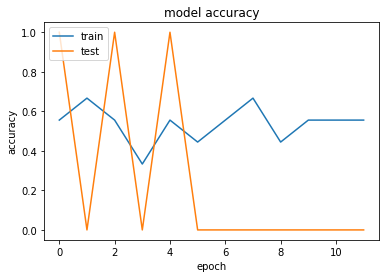

1/1 [==============================] - 0s 35ms/step - loss: 0.0000e+00 - accuracy: 1.0000


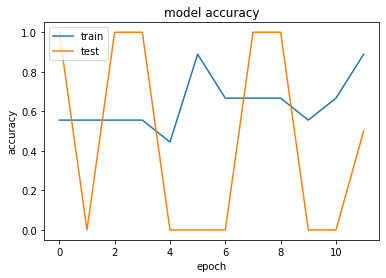

1/1 [==============================] - 0s 33ms/step - loss: 0.5276 - accuracy: 1.0000


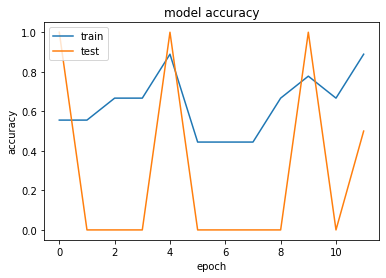

1/1 [==============================] - 0s 32ms/step - loss: 0.0624 - accuracy: 1.0000


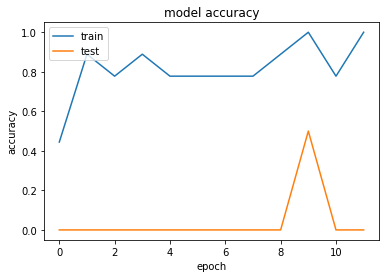

1/1 [==============================] - 0s 37ms/step - loss: 0.0046 - accuracy: 1.0000


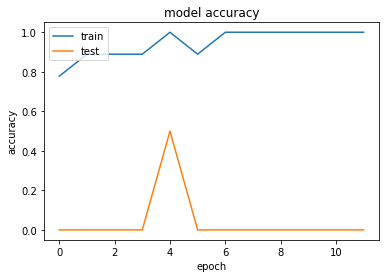

1/1 [==============================] - 0s 36ms/step - loss: 0.0116 - accuracy: 1.0000


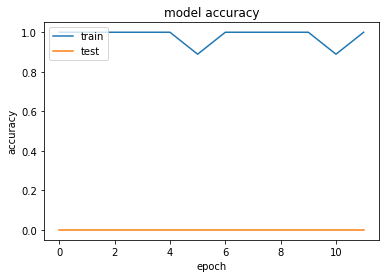

1/1 [==============================] - 0s 40ms/step - loss: 0.0167 - accuracy: 1.0000


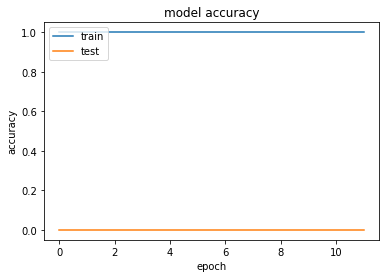

1/1 [==============================] - 0s 31ms/step - loss: 5.9605e-07 - accuracy: 1.0000


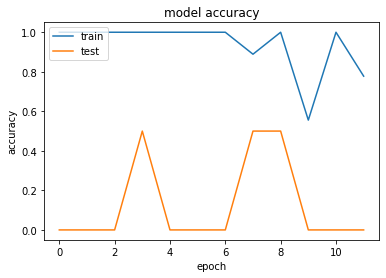

1/1 [==============================] - 0s 39ms/step - loss: 0.4363 - accuracy: 1.0000


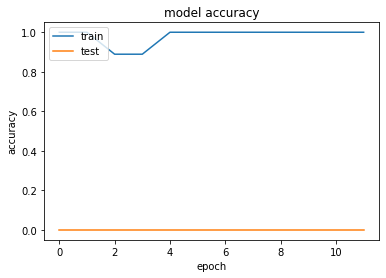

1/1 [==============================] - 0s 36ms/step - loss: 0.0000e+00 - accuracy: 1.0000


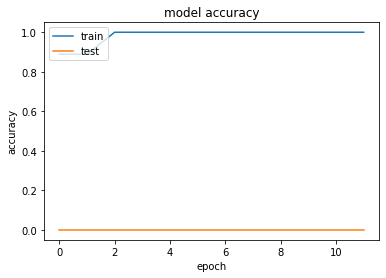

1/1 [==============================] - 0s 31ms/step - loss: 0.0085 - accuracy: 1.0000


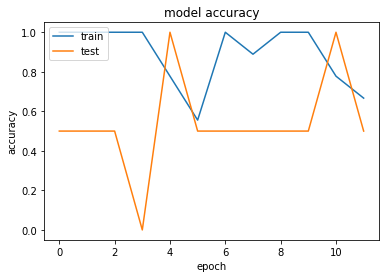

1/1 [==============================] - 0s 34ms/step - loss: 72.7042 - accuracy: 0.0000e+00


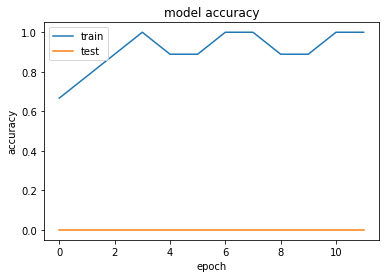

0.9166666666666666


In [ ]:
print(np.sum(custom_LOO(X, y, custom_VGG16(), "VGG16"))/12)

1/1 [==============================] - 1s 699ms/step - loss: 0.5795 - accuracy: 1.0000


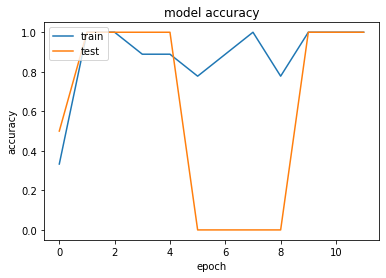

1/1 [==============================] - 0s 40ms/step - loss: 0.2773 - accuracy: 1.0000


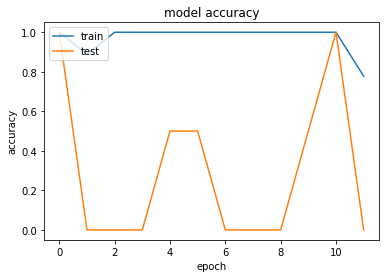

1/1 [==============================] - 0s 39ms/step - loss: 0.0000e+00 - accuracy: 1.0000


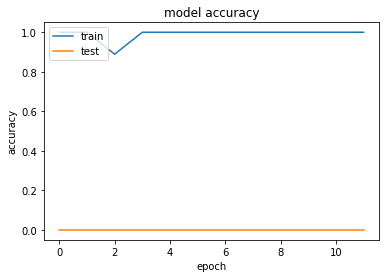

1/1 [==============================] - 0s 39ms/step - loss: 0.0000e+00 - accuracy: 1.0000


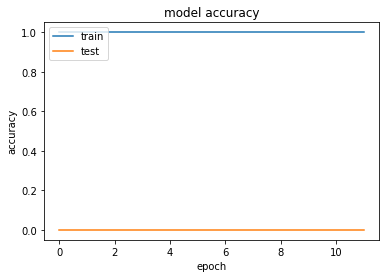

1/1 [==============================] - 0s 41ms/step - loss: 0.0000e+00 - accuracy: 1.0000


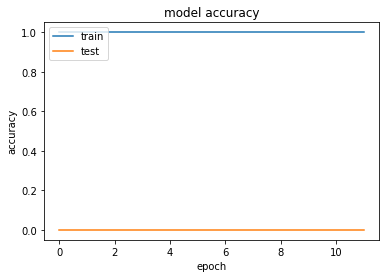

1/1 [==============================] - 0s 38ms/step - loss: 0.0000e+00 - accuracy: 1.0000


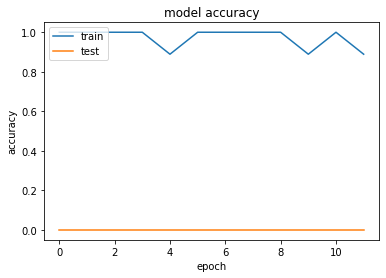

1/1 [==============================] - 0s 42ms/step - loss: 28.6409 - accuracy: 0.0000e+00


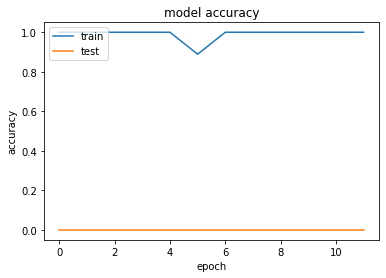

1/1 [==============================] - 0s 39ms/step - loss: 35.5457 - accuracy: 0.0000e+00


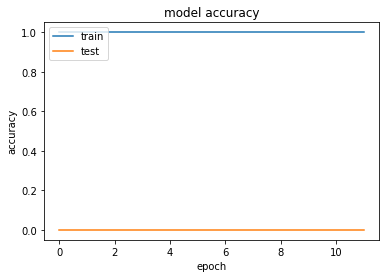

1/1 [==============================] - 0s 46ms/step - loss: 0.0000e+00 - accuracy: 1.0000


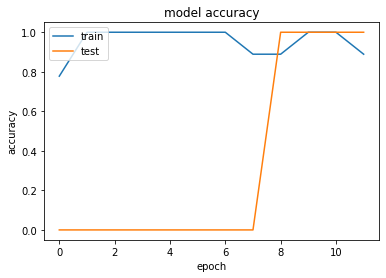

1/1 [==============================] - 0s 42ms/step - loss: 0.0000e+00 - accuracy: 1.0000


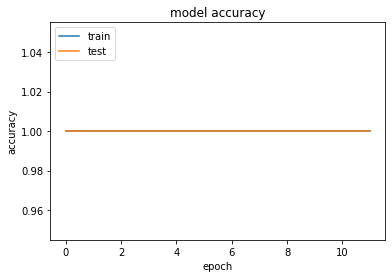

1/1 [==============================] - 0s 38ms/step - loss: 0.0000e+00 - accuracy: 1.0000


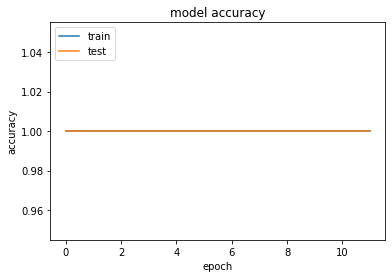

1/1 [==============================] - 0s 39ms/step - loss: 17.7726 - accuracy: 0.0000e+00


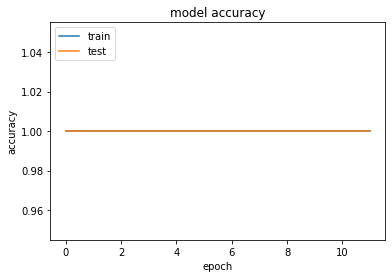

0.75


In [ ]:
print(np.sum(custom_LOO(X, y, custom_InceptionV3(), "Incep"))/12)
#custom_InceptionV3().summary()

In [ ]:
print(np.sum(custom_LOO(X, y, custom_ResNet50V2(), "ResNet"))/12)
# print(custom_ResNet50V2().summary())

InvalidArgumentError: ignored

Verificar pra fazer algo customizado e alterar o classiicador por meio de um laço, fica bala

Antes tava fazendo 50% treino e 50% teste, por isso o 0.333333...

> Mount e Defines

>  Funções que abrem a imagem

> *   openImgs()
*   join()
*   joi_open_file()
*   def VGG16(), InceptionV3() e ResNet50V2()
*   chamadas das redes usando o Leave-One-Out
*   chamada dos summary() das redes

> Problemas não resolvidos
>* por algum caralho de motivo, a rede recebe os parametros de shape_w e shape_h invertidos. Se tenta inverter a rede dá um erro de "ResourceExhaustedError: Graph execution error"

* por outro caralho de motivo, conforme vai rodando, vão sendo criados mais checkpoints que filho de pobre esperando bolsa familia 

> Problemas resolvidos

In [ ]:
custom_VGG16().summary()
custom_ResNet50V2().summary()
#custom_InceptionV3().summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.333
session = InteractiveSession(config=config)

# model code as usual down here